In [1]:
import json
import pandas as pd 
import numpy as np
import os
import re
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Ensure all densities are normalized to sum to 1
def normalize_density(density):
    return density / np.sum(density)
# Mutual Information calculation
def kl_divergence(p_density, q_density):
    p_density = normalize_density(p_density)
    q_density = normalize_density(q_density)
    return entropy(p_density, q_density)

# Count the number of elements in a list
def count_elements(item):
    if isinstance(item, list):
        return len(item)
    else:
        return 1

In [5]:
language_mapping = {
    'cantonese': 'CAN',
    'thai': 'THA',
    'japanese': 'JPN',
    'korean': 'KOR',
    'malay': 'MAL',
    'mandarin': 'MAN',
    'mono_eng': 'ENG',
    'urdu': 'URD'
}

real_language_mapping = {
    'HKG': 'CAN', 
    'THA': 'THA', 
    'JPN': 'JPN', 
    'KOR': 'KOR', 
    'MYS': 'MAL', 
    'CHN': 'MAN',  
    'ENS': 'ENG',  
    'PAK': 'URD',  
}

real_path_mapping = {'SD_1_Classified_Unmerged_qn': "Quantifiers Numerals",
                'SD_1_Classified_Unmerged_na': "Numbers Agreement",
                'SD_1_Classified_Unmerged_rw': "Reference Word",
                'SD_1_Classified_Unmerged_ta': "Tense Agreement",
                'SD_1_Classified_Unmerged_mve': "Modal Verbs Expressions",
                'SD_1_Classified_Unmerged_sva': "Subject Verb Agreement",
                'SD_1_Classified_Unmerged_sa': "Speech Acts",
                'SD_1_Classified_Unmerged_nvc': "Noun Verb Collocation"
                }

path_mapping = {'gpt_generation_quantifiers_numerals': "Quantifiers Numerals",
                'gpt_generation_tense_agreemen': "Tense Agreement",
                'gpt_generation_reference_word': "Reference Word",
                'gpt_generation_numbers_agreemen': "Numbers Agreement",
                'gpt_generation_speech_acts': "Speech Acts",
                'gpt_generation_subject_verb_agreemen': "Subject Verb Agreement",
                'gpt_generation_modal_verbs_expressions': "Modal Verbs Expressions",
                'gpt_generation_noun_verb_collocation': "Noun Verb Collocation"
                }

revert_mapping = {v: k for k, v in path_mapping.items()}
revert_real_mapping = {v: k for k, v in real_path_mapping.items()}

revert_lan_mapping = {v: k for k, v in language_mapping.items()}
revert_lan_real_mapping = {v: k for k, v in real_language_mapping.items()}

total_language_list = list(real_language_mapping.values())
real_language_list = list(real_language_mapping.keys())
total_feature_list = list(path_mapping.values())

In [6]:
# Put data under /data/gpt_annotations
path = '../data/gpt_annotations/'
for root, folders, files in os.walk(path):
    folder_list = folders
    break

# Put real data under /data/ICNALE_annotations
real_path = '../data/ICNALE_annotations'
for root, folders, files in os.walk(real_path):
    real_folder_list = folders
    break

In [22]:
overall_data = pd.DataFrame()
for topic in total_feature_list:
    if topic == "Noun Verb Collocation":
        continue
    feature = revert_mapping[topic]
    pattern = r"([^/]+)_dialog$"
    path = f'../data/gpt_annotations/{feature}'

    all_data = pd.DataFrame()
    count = 0
    for root, _, files in os.walk(path):
        if count == 0:
            count = count+1
            continue 
        language = re.search(pattern, root).group(1)
        for json_file in files:
            if json_file.endswith('.json'):
                file_path = os.path.join(root, json_file)
                try:
                    data = pd.read_json(file_path)
                    filename = os.path.splitext(json_file)[0]
                    data['source_file'] = filename
                    data['language'] = language
                    all_data = pd.concat([all_data, data], ignore_index=True)
                except ValueError as e:
                    print(f"Error reading {file_path}: {e}")
        count = count + 1
        
    if feature in [revert_mapping['Reference Word'],
                revert_mapping['Numbers Agreement'],
                revert_mapping['Modal Verbs Expressions'],
                revert_mapping['Noun Verb Collocation']
    ]:
        all_data['token_num'] = 1
    else:
        all_data['token_num'] = all_data['annotation_token'].apply(count_elements)

    all_data['type'] = topic
    all_data['language'] = all_data['language'].map(language_mapping)
    overall_data = pd.concat([overall_data, all_data], ignore_index=True)

In [28]:
restructure = overall_data.groupby(['source_file', 'language', 'type'])['token_num'].sum().unstack().reset_index(drop=False)
restructure = restructure.fillna(0)

In [33]:
restructure_drop = restructure.drop(columns=['source_file'])

In [77]:
features = [x for x in list(revert_mapping.keys()) if x != 'Noun Verb Collocation']

languages = ['JPN', 'ENG']
languages = language_mapping.values()
df_target = restructure_drop[restructure_drop['language'].isin(languages)]

X = df_target[features]
Y = df_target['language']

/Users/xuetongwu/opt/anaconda3/envs/strongroom/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


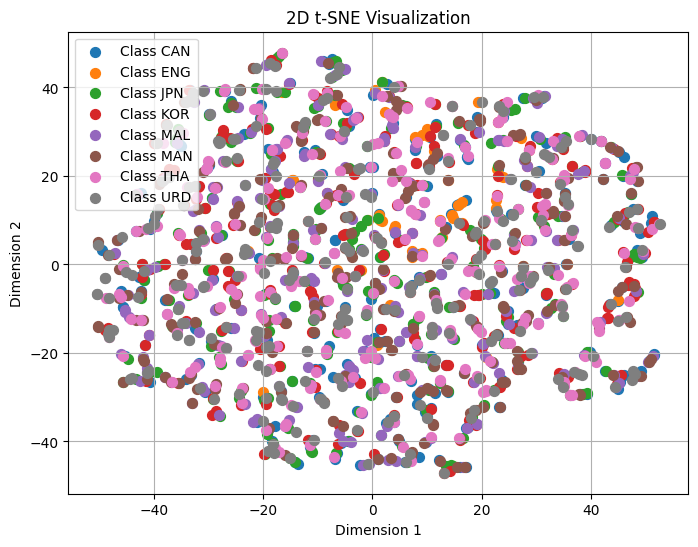

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=2042, perplexity=5, n_iter=500)
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['label'] = Y.values

plt.figure(figsize=(8, 6))
for label in np.unique(Y):
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['Dim1'], subset['Dim2'], label=f'Class {label}', s=50)

plt.title('2D t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()